Мышковец С.А., v.01 18.12.2022

Решение задачи: Кластеризация текстовых данных.
    
1. Из текстуальных данных с использованием алгоритмов кластеризации найти похожие. 
2. В выводах обосновать какие метрики и алгоритмы лучше использовать для решения вышеизложенных задач.

Выводы:

1. Построить рекомендательную систему удалось.
2. Метод локтя не позволил четко определить кол-во кластеров.
3. Оба метода кластеризации позволили достаточно верно определить тему новостей, хотя k-средних кластеризация показала лучший результат и максимальную V-меру.
    

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

np.random.seed(0)

# Загрузка данных

Открываем файл.

In [2]:
with open('news.txt', "r", encoding='utf_8_sig') as file:
   text = file.read()

In [3]:
# text

In [4]:
news = text.split('\n\n')

In [5]:
# news

# Предварительная обрабатка текста (препроцессинг)

Определяем длину текста.

In [6]:
len(text)

14759

In [7]:
len(text)

14759

Приводим символы в единый регистр (нижний).

In [8]:
news_lower = []
for i in news:
    i_lower = i.lower()
    news_lower.append(i_lower)

In [9]:
news_lower[0]

'1. в 2017 году, по данным журнала forbes, на американском курорте палм-бич (флорида) жило как минимум 30 долларовых миллиардеров. это объясняет местные цены на недвижимость, тем более когда речь идет о целом острове. в случае успешной продажи он должен стать самым дорогим в своем роде объектом во всем штате. остров тарпон площадью чуть меньше гектара — единственный находящийся в частной собственности у побережья палм-бич. его соорудили намывным способом еще в 1930-е годы, и последний раз он менял владельца в 1998-м. с городом его соединяет мост, но будущие собственники смогут попасть на его территорию на яхте.'

Очищаем текст от знаков пунктуации, лишних пробельных символов и цифр:

- выводим все знаки пунктуации.

In [10]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


- добавляем к знакам пунктуации символы переноса строки, табуляции и другие символы.

In [11]:
spec_chars = string.punctuation + '\n\xa0«»\t—…'

- удаляем символы:
  - используем поэлементную обработку строки: разделяем исходную строку text на символы,
  - оставляем только символы, не входящие в набор spec_chars
  - объединяем список символов в строку

In [12]:
def remove_chars_from_text(text, chars):
    return "".join([ch for ch in text if ch not in chars])

In [13]:
news_lower_nospec_chars = []
for i in news_lower:
    i = remove_chars_from_text(i, string.digits)
    i = remove_chars_from_text(i, spec_chars)
    news_lower_nospec_chars.append(i)

In [14]:
news_lower_nospec_chars[0]

' в  году по данным журнала forbes на американском курорте палмбич флорида жило как минимум  долларовых миллиардеров это объясняет местные цены на недвижимость тем более когда речь идет о целом острове в случае успешной продажи он должен стать самым дорогим в своем роде объектом во всем штате остров тарпон площадью чуть меньше гектара  единственный находящийся в частной собственности у побережья палмбич его соорудили намывным способом еще в е годы и последний раз он менял владельца в м с городом его соединяет мост но будущие собственники смогут попасть на его территорию на яхте'

# Токенизизация и лемматизация текста

Разбиваем очищенный текст на составные части – токены. Для задачи частотного анализа необходимо разбить текст на слова. Для этого используем готовый метод библиотеки nltk.

In [15]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\myshk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
from nltk import word_tokenize

news_tokens = []

for i in news_lower_nospec_chars:
    i_tokens = word_tokenize(i)
    news_tokens.append(i_tokens)

In [17]:
# news_tokens

Вычисляем количество слов в предобработанном тексте.

In [18]:
length = []
for i in news_tokens:
    length.append(len(i))

In [19]:
sum(length)

1990

Лемматизируем полученный список слов.

In [20]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
news_tokens_normal_form = []

In [21]:
for i in news_tokens:
    i_tokens_normal_form = []
    for word in i:
        p = morph.parse(word)[0]
        i_tokens_normal_form.append(p.normal_form)
    news_tokens_normal_form.append(i_tokens_normal_form)

In [22]:
# news_tokens_normal_form

# Удаление стоп-слов

In [23]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\myshk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Получаем список стоп-слов для русского языка

In [24]:
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")

По необходимости расширяем список стоп-слов.

In [25]:
russian_stopwords.extend(['это', 'нею', '–', '“', '”', 'весь', 'который', 'изз', 'лишь', 'ещё', 'поскольку', 'свой', 'наш', 'ваш'])

Получаем список слов, не входящих в список стоп-слов.

In [26]:
news_tokens = []
for i in news_tokens_normal_form:
    i_tokens = [x for x in i if x not in russian_stopwords]
    news_tokens.append(i_tokens)

In [27]:
# news_tokens

TfidfVectorizer() принимает аргументом список строк, а не список списков.

In [28]:
news_tokens_list = []
for i in news_tokens:
    i = ' '.join(i)
    news_tokens_list.append(i)

In [29]:
news_tokens_list[0]

'год данные журнал forbes американский курорт палмбич флорида жить минимум долларовый миллиардер объяснять местный цена недвижимость речь идти целое остров случай успешный продажа должный стать самый дорогой род объект штат остров тарпон площадь маленький гектар единственный находиться частный собственность побережье палмбич соорудить намывной способ е год последний менять владелец метр город соединять мост будущий собственник смочь попасть территория яхта'

# Перевод в векторное представление

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(news_tokens_list)
vectorizer.get_feature_names_out()
X.shape

(13, 940)

In [31]:
df = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Columns: 940 entries, advance to яхта
dtypes: float64(940)
memory usage: 95.6 KB


In [32]:
df.shape

(13, 940)

In [33]:
df

,advance,amazon,att,autogrodnoby,bros,building,changan,chronicle,depo,dolbyавтор,...,энергия,эпизод,эпоха,эстетический,эффектный,юзеф,являться,явно,ядерный,яхта
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.139151
1,0.000000,0.000000,0.126422,0.000000,0.000000,0.063211,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.063211,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.137211,0.000000,...,0.00000,0.000000,0.068606,0.000000,0.068606,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.07015,0.000000,0.000000,0.000000,0.000000,0.000000,0.060495,0.000000,0.000000,0.000000
4,0.135053,0.000000,0.000000,0.000000,0.000000,0.000000,0.135053,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090012,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.159796,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.159796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.121238,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.121238,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.125183,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.075395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.075395,0.000000,0.000000,0.000000,0.000000


# Кластеризация

In [34]:
targets = [0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 2, 1, 0]

In [35]:
from sklearn.cluster import KMeans

clusters = range(1, 7)
inertias = []
for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(X)
    inertias.append(model.inertia_)

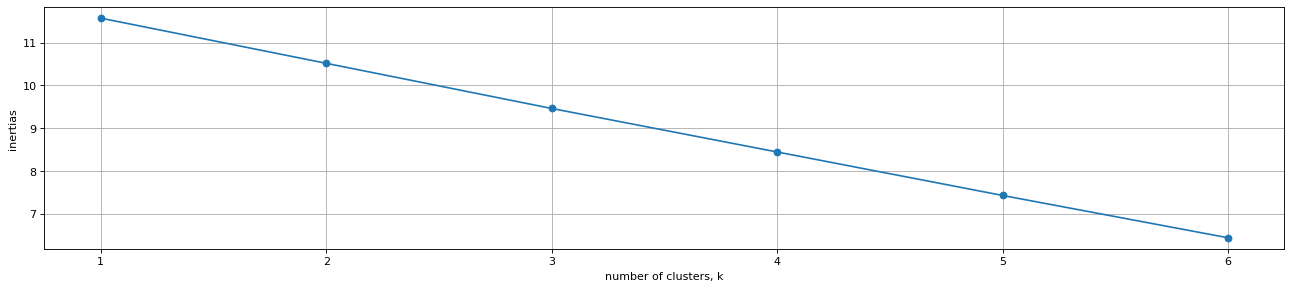

In [36]:
plt.figure(figsize=(20, 4), dpi=80)
plt.plot(clusters, inertias, marker='o');
plt.grid(True)
plt.xticks(clusters)
plt.xlabel('number of clusters, k')
plt.ylabel('inertias');

## KMeans

In [37]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3, n_init=100)
model.fit(X)
labels_kmeans = model.predict(X)

In [38]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(targets, labels_kmeans)

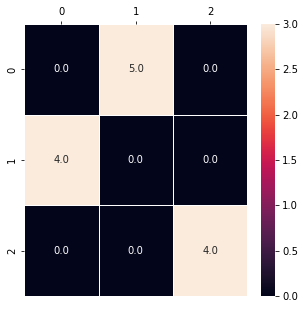

In [39]:
import pandas as pd

fig, ax = plt.subplots(figsize=(5, 5))
df_cm = pd.DataFrame(confusion_matrix)
ax = sns.heatmap(df_cm, annot=True, fmt=".1f", linewidth=.5, vmax=3)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

In [40]:
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score

silhouette_kmeans = silhouette_score(X, labels_kmeans)
v_measure_kmeans = v_measure_score(targets, labels_kmeans)

In [41]:
silhouette_kmeans

0.011109145726752864

In [42]:
v_measure_kmeans

1.0

# Иерархическая кластеризация.

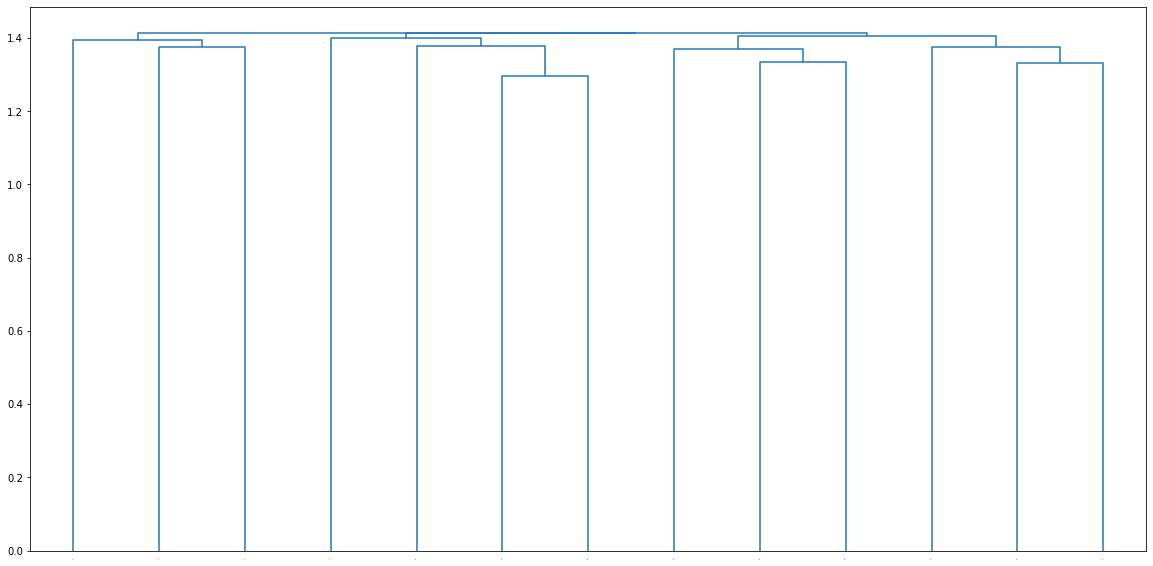

In [43]:
from scipy.cluster.hierarchy import linkage, dendrogram

fig = plt.figure(figsize = [20, 10])
mergings = linkage(X.toarray(), method='complete')
dendrogram(mergings, labels=targets, leaf_rotation=90, leaf_font_size=2)
plt.show()

Дендрограмма не совсем подходит для решения задачи.

In [44]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

clustering = AgglomerativeClustering(n_clusters=3).fit(X.toarray())
labels_agg = clustering.fit_predict(X.toarray())
labels_agg_ = clustering.labels_

In [45]:
labels_agg

array([0, 0, 0, 1, 1, 1, 2, 0, 2, 0, 2, 1, 0], dtype=int64)

In [46]:
labels_agg_

array([0, 0, 0, 1, 1, 1, 2, 0, 2, 0, 2, 1, 0], dtype=int64)

In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix_agg = confusion_matrix(targets, labels_agg)

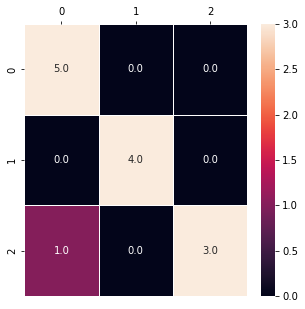

In [48]:
fig, ax = plt.subplots(figsize=(5, 5))
df_cm = pd.DataFrame(confusion_matrix_agg)
ax = sns.heatmap(df_cm, annot=True, fmt=".1f", linewidth=.5, vmax=3)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

In [49]:
silhouette_agg = silhouette_score(X, labels_agg)
v_measure_agg = v_measure_score(targets, labels_agg)

In [50]:
silhouette_agg

0.01358819174759348

In [51]:
v_measure_agg

0.8228617880719772

## Оба метода кластеризации позволили достаточно верно определить тему новостей, хотя k-средних кластеризация показала лучший результат и максимальную V-меру.